In [1]:
from jrieke import interpretation
from jrieke.utils import load_nifti
import jrieke.models as models
import torch
from innvestigator import InnvestigateModel
from copy import deepcopy
from jrieke import interpretation
import jrieke.utils as utils
import matplotlib.colors as mcolors

from copy import deepcopy
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

from settings import settings
from utils import load_data
from nmm_mask_areas import short_name_map
for k in settings.keys():
    print("Adding " + k + " to namespace")
    globals()[k] = settings[k]

Adding model_path to namespace
Adding ADNI_DIR to namespace
Adding binary_brain_mask to namespace
Adding 1.5T_table to namespace
Adding 3T_table to namespace
Adding 3T_image_dir to namespace
Adding 1.5T_image_dir to namespace
Adding data_path to namespace
Adding nmm_mask_path to namespace


#### Load results from evaluation notebook

In [2]:
cases = ["AD", "HC", "TP", "TN", "FP", "FN"]

mean_maps_LRP = dict()
mean_maps_GB = dict()
rs_per_area_LRP = dict()
rs_per_area_GB = dict()
for case in cases:
    mean_maps_LRP[case] = load_nifti(os.path.join(data_path, "LRP_{case}.nii".format(case=case)))
    mean_maps_GB[case] = load_nifti(os.path.join(data_path, "GB_{case}.nii".format(case=case)))
    with open(os.path.join(data_path, "LRP_area_evdcs_{case}.pkl".format(case=case)), 'rb') as file:
        rs_per_area_LRP[case] = pickle.load(file)
    with open(os.path.join(data_path, "GB_area_evdcs_{case}.pkl".format(case=case)), 'rb') as file:
        rs_per_area_GB[case] = pickle.load(file)

nmm_mask = load_nifti(os.path.join(data_path, "rescaled_nmm_mask.nii"))
with open(os.path.join(data_path, 'area_sizes.pkl'), 'rb') as file:
    area_sizes = pickle.load(file)
    
ad_score_list = np.loadtxt(os.path.join(data_path, "ad_scores.txt"))

#### Load test dataset for individual brains

In [3]:
train_dataset, test_dataset = load_data()

Loading dataframe for /analysis/ritter/data/ADNI/ADNI_tables/customized/DxByImgClean_CompleteAnnual2YearVisitList_1_5T.csv
Found 1590 images in table
Filtered out 2 of 1590 images because of failed preprocessing
Filtered out 0 of 1588 images because of missing files
Filtered out 619 of 1588 images that were MCI
Final dataframe contains 969 images from 344 patients

         Images    -> AD    -> CN    Patients    -> AD    -> CN
-----  --------  -------  -------  ----------  -------  -------
All         969      475      494         344      193      151
Train       794      399      395         284      163      121
Val         175       76       99          60       30       30

Calculating mean and std for normalization:


# Plotting brain maps

In [4]:
shape = mean_maps_LRP["AD"].shape

### Getting contours for areas

In [5]:
from nmm_mask_areas import all_areas

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_colors = [name for hsv, name in by_hsv]
contour_configs = {name: (mini, maxi, cname) for (name, (mini, maxi)), cname in zip(all_areas.items(), sorted_colors[::2])}
contours = {k:None for k in contour_configs.keys()}
for key, (mini, maxi, col) in contour_configs.items():
    tmp_map = np.zeros_like(nmm_mask)
    tmp_map[np.logical_and(nmm_mask>=mini, nmm_mask<=maxi) ] = 40
    contours[key] = tmp_map


## Plotting functions

In [6]:
def plot_contours(areas, x_idx, y_idx, z_idx, c, fig=None, ax=None):
    
    if not areas:
        return
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(12, 12))

    for c_ , name in zip(c, areas):

        cmap_area = mcolors.LinearSegmentedColormap.from_list(
            name="colored", colors=[(0,0,0,0), c_], N=100)
        cmap_area_border_b = mcolors.LinearSegmentedColormap.from_list(
            name="black", colors=[(0,0,0,0), "black"], N=100)
        cmap_area_border_w = mcolors.LinearSegmentedColormap.from_list(
            name="white", colors=[(0,0,0,0), "white"], N=100)
        slice_area = contours[name][x_idx, y_idx, z_idx].T

        cs_ad = ax.contour(slice_area, [0, 10], cmap=cmap_area, linewidths=3, alpha=1, bordercolors="black",
                          label= " ".join(areas))


In [7]:
def plot_idv_brain(heat_map, brain_img, ref_scale, fig=None, ax=None, contour_areas=[],
                  x_idx=slice(0, shape[0]), y_idx=slice(0, shape[1]), z_idx=slice(0, shape[2]),
                  vmin=90, vmax=99.5, set_nan=True, cmap=None, c=None):

    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(12, 12))
    
    img = deepcopy(heat_map)
    if set_nan:
        img[nmm_mask==0]=np.nan
    if cmap is None:
        cmap = mcolors.LinearSegmentedColormap.from_list(name='alphared',
                                                  colors=[(1, 0, 0, 0),
                                                         "darkred", "red", "darkorange", "orange", "yellow"],
                                                  N=5000)
        
    if brain_img is not None:
        ax.imshow(brain[x_idx, y_idx, z_idx].T, cmap="Greys",
                 vmin=grey_vmin, vmax=grey_vmax)

    vmin, vmax = np.percentile(ref_scale, vmin), np.percentile(ref_scale, vmax)
    im = ax.imshow(img[x_idx, y_idx, z_idx].T, cmap=cmap, 
               vmin=vmin, vmax=vmax, interpolation="gaussian")
    
   
    ax.axis('off')
    

    plot_contours(contour_areas, x_idx, y_idx, z_idx, fig=fig, ax=ax, c=c)
    plt.gca().invert_yaxis()
    return fig, ax, im


## Individual maps

##### Load model

In [8]:
net = models.ClassificationModel3D()
net.cpu()
net.eval()
net.load_state_dict(torch.load(model_path,
                              map_location='cpu'))
net = torch.nn.Sequential(net, torch.nn.Softmax(dim=1))
inn_model = InnvestigateModel(net, lrp_exponent=1,
                                  method="b-rule",
                                  beta=.5, epsilon=1e-6).cpu()
inn_model.eval();


### Obtaining individual heatmaps

In [9]:
def run_guided_backprop(net, image_tensor):
    return interpretation.guided_backprop(net, image_tensor, cuda=False, verbose=False, apply_softmax=False)

def run_LRP(net, image_tensor):
    return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=1)

def get_heatmaps(idx):
    image_tensor, label = test_dataset[idx]
    image_tensor = image_tensor[None]
    image_tensor_LRP = image_tensor.cpu()
    print("Running GB")
    rel_GB = run_guided_backprop(inn_model, image_tensor_LRP)
    print("Running LRP")
    AD_score, rel_LRP = run_LRP(inn_model, image_tensor_LRP)
    print(label, AD_score)
    return rel_LRP.squeeze().detach().cpu().numpy().squeeze(), rel_GB.squeeze()

In [ ]:
patientA, patientB = 86, 0
brain_A, brain_B = test_dataset[patientA][0][0].numpy(), test_dataset[patientB][0][0].numpy()
grey_vmin, grey_vmax = np.min([brain_A, brain_B]), np.max([brain_A, brain_B])

LRP_map_patient_A, GB_map_patient_A = get_heatmaps(patientA)
LRP_map_patient_B, GB_map_patient_B = get_heatmaps(patientB)


Running GB
Running LRP
tensor(1) tensor([[0.0770, 0.9230]])
Running GB
Running LRP


##### Define brain slices

In [ ]:
first_slice=60
first_areas = ["Hippocampus", "TTG", "STG", "Caudate", "PT", "Amygdala"]
second_slice=86
second_areas = first_areas
third_slice=91
third_areas = first_areas
# Colors for areas
cs= ["lawngreen", "cyan", "black", "blue", "red", "deepskyblue"]

# Plotting

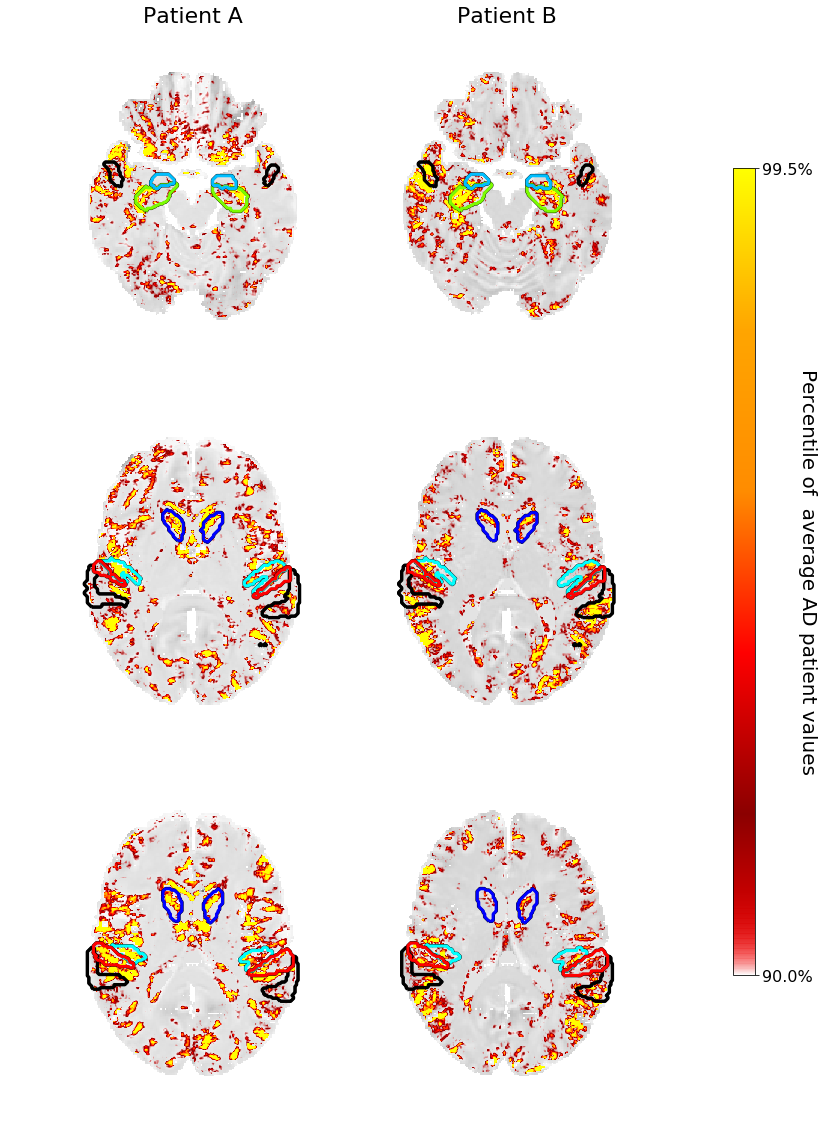

In [53]:
brain = deepcopy(brain_A)
brain[nmm_mask==0] = np.nan
vmin, vmax = 90, 99.5
fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(12, 16), sharey=True)

fig, ax, im = plot_idv_brain(LRP_map_patient_A, brain, mean_maps_LRP["AD"], z_idx=first_slice, 
                              contour_areas=first_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax1[1],
                             c=cs);
ax.set_title("Patient B", fontsize=22)
ax.set_ylabel("Slice number " + str(first_slice))

fig, ax, im = plot_idv_brain(LRP_map_patient_A, brain, mean_maps_LRP["AD"], z_idx=second_slice, 
                              contour_areas=second_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax2[1],
                             c=cs);
ax.set_ylabel("Slice number " + str(second_slice))


fig, ax, im = plot_idv_brain(LRP_map_patient_A, brain, mean_maps_LRP["AD"], z_idx=third_slice, 
                              contour_areas=third_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax3[1],
                             c=cs);
ax.set_ylabel("Slice number " + str(third_slice))

brain = deepcopy(brain_B)
brain[nmm_mask==0] = np.nan


fig, ax, im = plot_idv_brain(LRP_map_patient_B, brain, mean_maps_LRP["AD"], z_idx=first_slice, 
                              contour_areas=first_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax1[0],
                             c=cs);
ax.set_title("Patient A", fontsize=22)

ax.set_ylabel("Slice number " + str(first_slice))

fig, ax, im = plot_idv_brain(LRP_map_patient_B, brain, mean_maps_LRP["AD"], z_idx=second_slice, 
                              contour_areas=second_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax2[0],
                             c=cs);

ax.set_ylabel("Slice number " + str(second_slice))


fig, ax, im = plot_idv_brain(LRP_map_patient_B, brain, mean_maps_LRP["AD"], z_idx=third_slice, 
                              contour_areas=third_areas,
                            vmin=vmin, vmax=vmax, fig=fig, ax=ax3[0],
                             c=cs);

ax.set_ylabel("Slice number " + str(third_slice))


fig.tight_layout()
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
cbar = fig.colorbar(im, shrink=0.5, ticks=[vmin, vmax], cax=cbar_ax)
vmin_val, vmax_val = np.percentile(mean_maps_LRP["AD"], vmin), np.percentile(mean_maps_LRP["AD"], vmax)
cbar.set_ticks([vmin_val, vmax_val])
cbar.ax.set_yticklabels(['{0:.1f}%'.format(vmin), '{0:.1f}%'.format(vmax)], fontsize=16)
cbar.set_label('Percentile of  average AD patient values', rotation=270, fontsize=20)
fig.savefig(os.path.join(data_path, "patient_brains.pdf"))

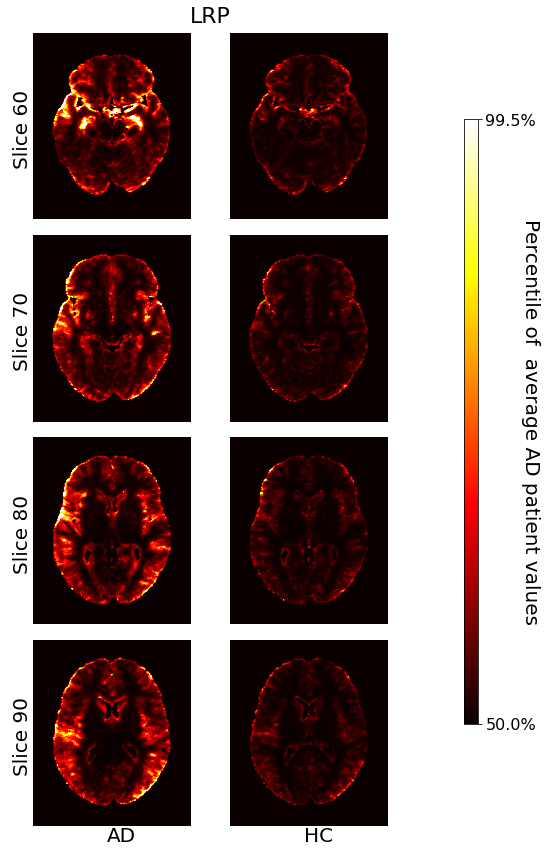

In [56]:
fig, axes = plt.subplots(4, 2, figsize=(8, 12), sharey=True, sharex=True)
vmin, vmax = 50, 99.5

for ax, idx in zip(axes[:, 0], [60, 70, 80, 90]):
    ax.text(-25, 140, "Slice " + str(idx), rotation="vertical", fontsize=20)

    fig, ax, im = plot_idv_brain(mean_maps_LRP["AD"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");
ax.text(90, -20, "AD", fontsize=20)

for ax, idx in zip(axes[:, 1], [60, 70, 80, 90]):

    fig, ax, im = plot_idv_brain(mean_maps_LRP["HC"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(90, -20, "HC", fontsize=20)
    
fig.tight_layout()
fig.subplots_adjust(right=0.8)
fig.subplots_adjust(top=0.95)
fig.suptitle("LRP", fontsize=22, x=.41)

cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
cbar = fig.colorbar(im, shrink=0.5, ticks=[vmin, vmax], cax=cbar_ax)


vmin_val, vmax_val = np.percentile(mean_maps_LRP["AD"], vmin), np.percentile(mean_maps_LRP["AD"], vmax)
cbar.set_ticks([vmin_val, vmax_val])
cbar.ax.set_yticklabels(['{0:.1f}%'.format(vmin), '{0:.1f}%'.format(vmax)],
                       fontsize=16)
cbar.set_label('Percentile of  average AD patient values', rotation=270, fontsize=20)
fig.savefig(os.path.join(data_path, "LRP_AD_HC_brain.pdf"))


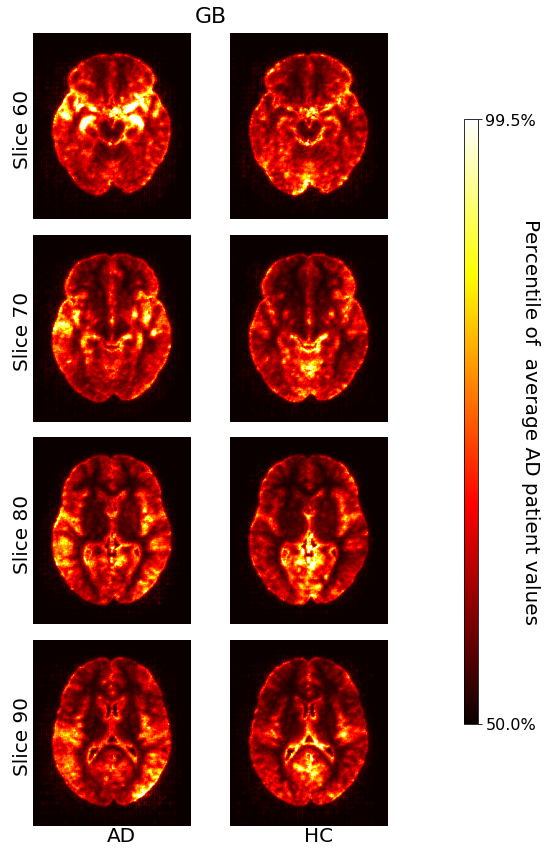

In [58]:
fig, axes = plt.subplots(4, 2, figsize=(8, 12), sharey=True, sharex=True)
vmin, vmax = 50, 99.5

for ax, idx in zip(axes[:, 0], [60, 70, 80, 90]):
    ax.text(-25, 140, "Slice " + str(idx), rotation="vertical", fontsize=20)

    fig, ax, im = plot_idv_brain(mean_maps_GB["AD"], None, mean_maps_GB["AD"], z_idx=idx, contour_areas=[],
                                vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");
ax.text(90, -20, "AD", fontsize=20)

for ax, idx in zip(axes[:, 1], [60, 70, 80, 90]):

    fig, ax, im = plot_idv_brain(mean_maps_GB["HC"], None, mean_maps_GB["AD"], z_idx=idx, contour_areas=[],
                                vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(90, -20, "HC", fontsize=20)
    
fig.tight_layout()
fig.subplots_adjust(right=0.8)
fig.subplots_adjust(top=0.95)
fig.suptitle("GB", fontsize=22, x=.41)

cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
cbar = fig.colorbar(im, shrink=0.5, ticks=[vmin, vmax], cax=cbar_ax)


vmin_val, vmax_val = np.percentile(mean_maps_GB["AD"], vmin), np.percentile(mean_maps_GB["AD"], vmax)
cbar.set_ticks([vmin_val, vmax_val])
cbar.ax.set_yticklabels(['{0:.1f}%'.format(vmin), '{0:.1f}%'.format(vmax)],
                       fontsize=16)
cbar.set_label('Percentile of  average AD patient values', rotation=270, fontsize=20)
fig.savefig(os.path.join(data_path, "GB_AD_HC_brain.pdf"))


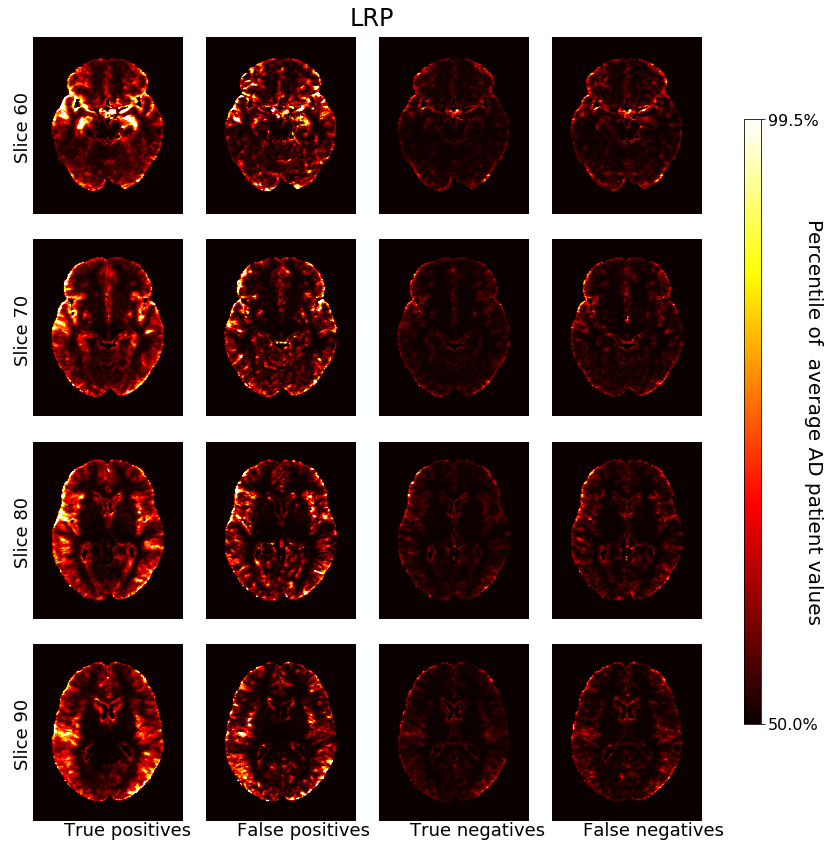

In [57]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12), sharey=True, sharex=True)
vmin, vmax = 50, 99.5

for ax, idx in zip(axes[:, 0], [60, 70, 80, 90]):
    ax.text(-25, 140, "Slice " + str(idx), rotation="vertical", fontsize=18)
    
    fig, ax, im = plot_idv_brain(mean_maps_LRP["TP"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(40, -20, "True positives", fontsize=18)

for ax, idx in zip(axes[:, 1], [60, 70, 80, 90]):
    fig, ax, im = plot_idv_brain(mean_maps_LRP["FP"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(40, -20, "False positives", fontsize=18)

for ax, idx in zip(axes[:, 2], [60, 70, 80, 90]):
    fig, ax, im = plot_idv_brain(mean_maps_LRP["TN"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");
ax.text(40, -20, "True negatives", fontsize=18)

for ax, idx in zip(axes[:, 3], [60, 70, 80, 90]):
    fig, ax, im = plot_idv_brain(mean_maps_LRP["FN"], None, mean_maps_LRP["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");
ax.text(40, -20, "False negatives", fontsize=18)

fig.suptitle("LRP", fontsize=24, x=.42)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, shrink=0.5, ticks=[vmin, vmax], cax=cbar_ax)

vmin_val, vmax_val = np.percentile(mean_maps_LRP["AD"], vmin), np.percentile(mean_maps_LRP["AD"], vmax)
cbar.set_ticks([vmin_val, vmax_val])
# plt.colorbar(aspect=20)

cbar.ax.set_yticklabels(['{0:.1f}%'.format(vmin), '{0:.1f}%'.format(vmax)],
                        fontsize=16)
cbar.set_label('Percentile of  average AD patient values', rotation=270, fontsize=20)
fig.savefig(os.path.join(data_path, "LRP_TP_FP_TN_FN_brain.pdf"))


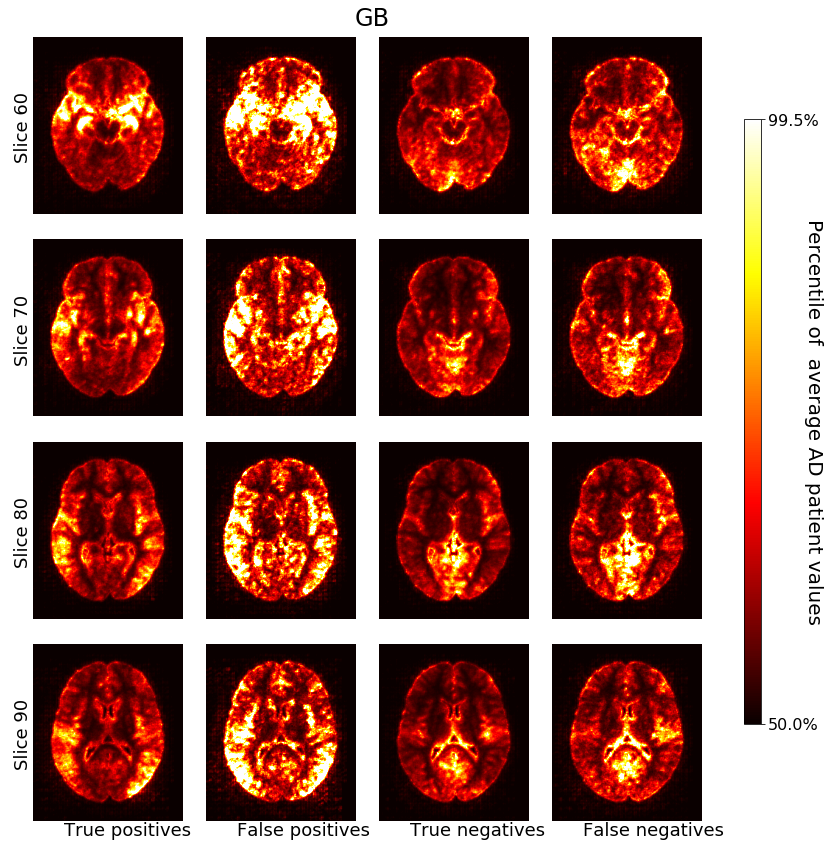

In [59]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12), sharey=True, sharex=True)
vmin, vmax = 50, 99.5

for ax, idx in zip(axes[:, 0], [60, 70, 80, 90]):
    ax.text(-25, 140, "Slice " + str(idx), rotation="vertical", fontsize=18)
    
    fig, ax, im = plot_idv_brain(mean_maps_GB["TP"], None, mean_maps_GB["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(40, -20, "True positives", fontsize=18)

for ax, idx in zip(axes[:, 1], [60, 70, 80, 90]):
    fig, ax, im = plot_idv_brain(mean_maps_GB["FP"], None, mean_maps_GB["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");

ax.text(40, -20, "False positives", fontsize=18)

for ax, idx in zip(axes[:, 2], [60, 70, 80, 90]):
    fig, ax, im = plot_idv_brain(mean_maps_GB["TN"], None, mean_maps_GB["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");
ax.text(40, -20, "True negatives", fontsize=18)

for ax, idx in zip(axes[:, 3], [60, 70, 80, 90]):
    fig, ax, im = plot_idv_brain(mean_maps_GB["FN"], None, mean_maps_GB["AD"], z_idx=idx, contour_areas=[],
                                 vmin=vmin, vmax=vmax, fig=fig, ax=ax, set_nan=False, cmap="hot");
ax.text(40, -20, "False negatives", fontsize=18)

fig.suptitle("GB", fontsize=24, x=.42)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, shrink=0.5, ticks=[vmin, vmax], cax=cbar_ax)

vmin_val, vmax_val = np.percentile(mean_maps_GB["AD"], vmin), np.percentile(mean_maps_GB["AD"], vmax)
cbar.set_ticks([vmin_val, vmax_val])
# plt.colorbar(aspect=20)

cbar.ax.set_yticklabels(['{0:.1f}%'.format(vmin), '{0:.1f}%'.format(vmax)],
                        fontsize=16)
cbar.set_label('Percentile of  average AD patient values', rotation=270, fontsize=20)
fig.savefig(os.path.join(data_path, "GB_TP_FP_TN_FN_brain.pdf"))
